# New Jersey Dickey-Fuller Tests & Modeling

Like we did for Connecticut, we found the top 3 zip codes for New Jersey. We'll be looking at 07756 - Ocean Grove, 07032 - Jersey City and 07030 - Hoboken.

Before we model, we first must satisfy the assumption of stationarity. Stationarity means that there is a constant mean and variance - or in other words, the mean and variance are not a function of time. We do so by running a Dickey-Fuller test where the null hypothesis is that there is no stationarity. In the case that there is in fact no stationarity, we will have to difference our data and rerun the Dickey-Fuller test. We repeat the process until the stationarity requirement is met.

Before we model, let's first import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore') 

### Functions for Dickey-Fuller Test

In [247]:
def graph_annual(df):
    """
    This function will graph the annual values for a given zipcode.
    """
    # We can only view the data for complete years so we want to limit the scope to be around 1997-2017
    ttl_year = df['1997-01':'2017-12']
    annual = ttl_year.groupby(pd.Grouper(freq = 'A'))
    annual_df = pd.DataFrame()
    for yr, group in annual:
        annual_df[yr.year] = group.values.ravel()
        
    annual_df.plot(figsize = (30,30), subplots=False, fontsize = 18)
    plt.legend(fontsize=14, loc=1) 
    plt.title("Annual Selling 1997-2017", fontsize=30);

In [248]:
def rolling_mean(df):
    # set the rolling mean and standard deviation
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    # plot the original data, rolling mean, and standard deviation
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [249]:
def dickeyfuller(df):
    # test for stationarity
    dftest = adfuller(df)
    # get test statistics
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('p-value:',dfoutput[1])
    if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')
    print ('Results of Dickey-Fuller test: \n')
    print(dfoutput)

In [250]:
def difference_data(df):
    return df.diff().dropna()

In [251]:
def plot_acf_pacf(df):
    plot_acf(df[:-1], alpha=0.5);
    plot_pacf(df[:-1], alpha=0.5);

### Read in Data

First, we need to read in the csv that we filtered for our top zip codes and melted our date data to be in long form.

In [257]:
topzip = pd.read_csv('topzip_timeseries.csv')
topzip

,time,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,AveragePrice,ROI,value
0,1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,9.577774e+05,5.148210,301600.0
1,1996-04-01,62022,11211,New York,NY,New York,Kings,118,5.951672e+05,11.189940,133200.0
2,1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,5.965913e+05,9.403061,137200.0
3,1996-04-01,62027,11216,New York,NY,New York,Kings,476,5.721717e+05,9.942505,146100.0
4,1996-04-01,62033,11222,New York,NY,New York,Kings,1156,6.400475e+05,10.535523,149200.0
...,...,...,...,...,...,...,...,...,...,...,...
2380,2018-04-01,62033,11222,New York,NY,New York,Kings,1156,6.400475e+05,10.535523,1721100.0
2381,2018-04-01,60461,6820,Darien,CT,Stamford,Fairfield,6037,1.128920e+06,1.514218,1388100.0
2382,2018-04-01,60796,7756,Neptune,NJ,New York,Monmouth,9759,3.456445e+05,4.418274,533700.0
2383,2018-04-01,60125,6068,Salisbury,CT,Torrington,Litchfield,13646,3.843411e+05,1.476514,474500.0


Now that we have our data, we want the time to be our index. Before we set the index, we also need to make sure it's in the 'datetime' format. This way we can slice the data later on.

In [258]:
topzip['time'] = pd.to_datetime(topzip['time'])
topzip.set_index('time', inplace=True)

In [259]:
### drop excess columns.

topzip.drop(columns=['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AveragePrice', 'ROI'], inplace=True)

In [260]:
### save a new dataframe for just New Jersey.

state_zips = [7756, 7302, 7030]

state = topzip[topzip['Zipcode'].isin(state_zips)]
state.head()

,Zipcode,value
time,,
1996-04-01,7030,301600.0
1996-04-01,7302,137200.0
1996-04-01,7756,98500.0
1996-05-01,7030,302700.0
1996-05-01,7302,137800.0


### First Zipcode: 07756 - Ocean Grove

Ocean Grove has become a hotspot for home values. You can find it along the Jersey Shore, but interestingly enough, it's a dry town - there are no bars or liquor stores in the place. It is truly a beach paradise to escape to. Prices in this zip have exploded over the years. Our first data point, the average value was only $\\$\$98.5k and by 2018 the average price jumped up to $534k. We need to check for stationarity, but just by the that window, I'll go ahead and say we need to difference this data.

In [261]:
first_zip = state[state['Zipcode'] == state_zips[0]]
first_zip.drop(columns=['Zipcode'], inplace=True)
first_zip.head()

,value
time,
1996-04-01,98500.0
1996-05-01,99100.0
1996-06-01,99600.0
1996-07-01,100300.0
1996-08-01,100900.0


Ocean Grove values increased over the years up until around 2008 where they dropped. They stayed around $\\$\$400k until 2017 when values took off to above $500k, higher than where it had been before the economic crisis.

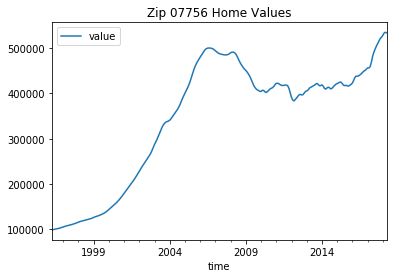

In [262]:
first_zip.plot(title="Zip 07756 Home Values");

We can see by year the steady increase in value year over year up until 2008 when the value dropped. In 2017, the value creeped back up and continued to do so in 2018 (not pictured).

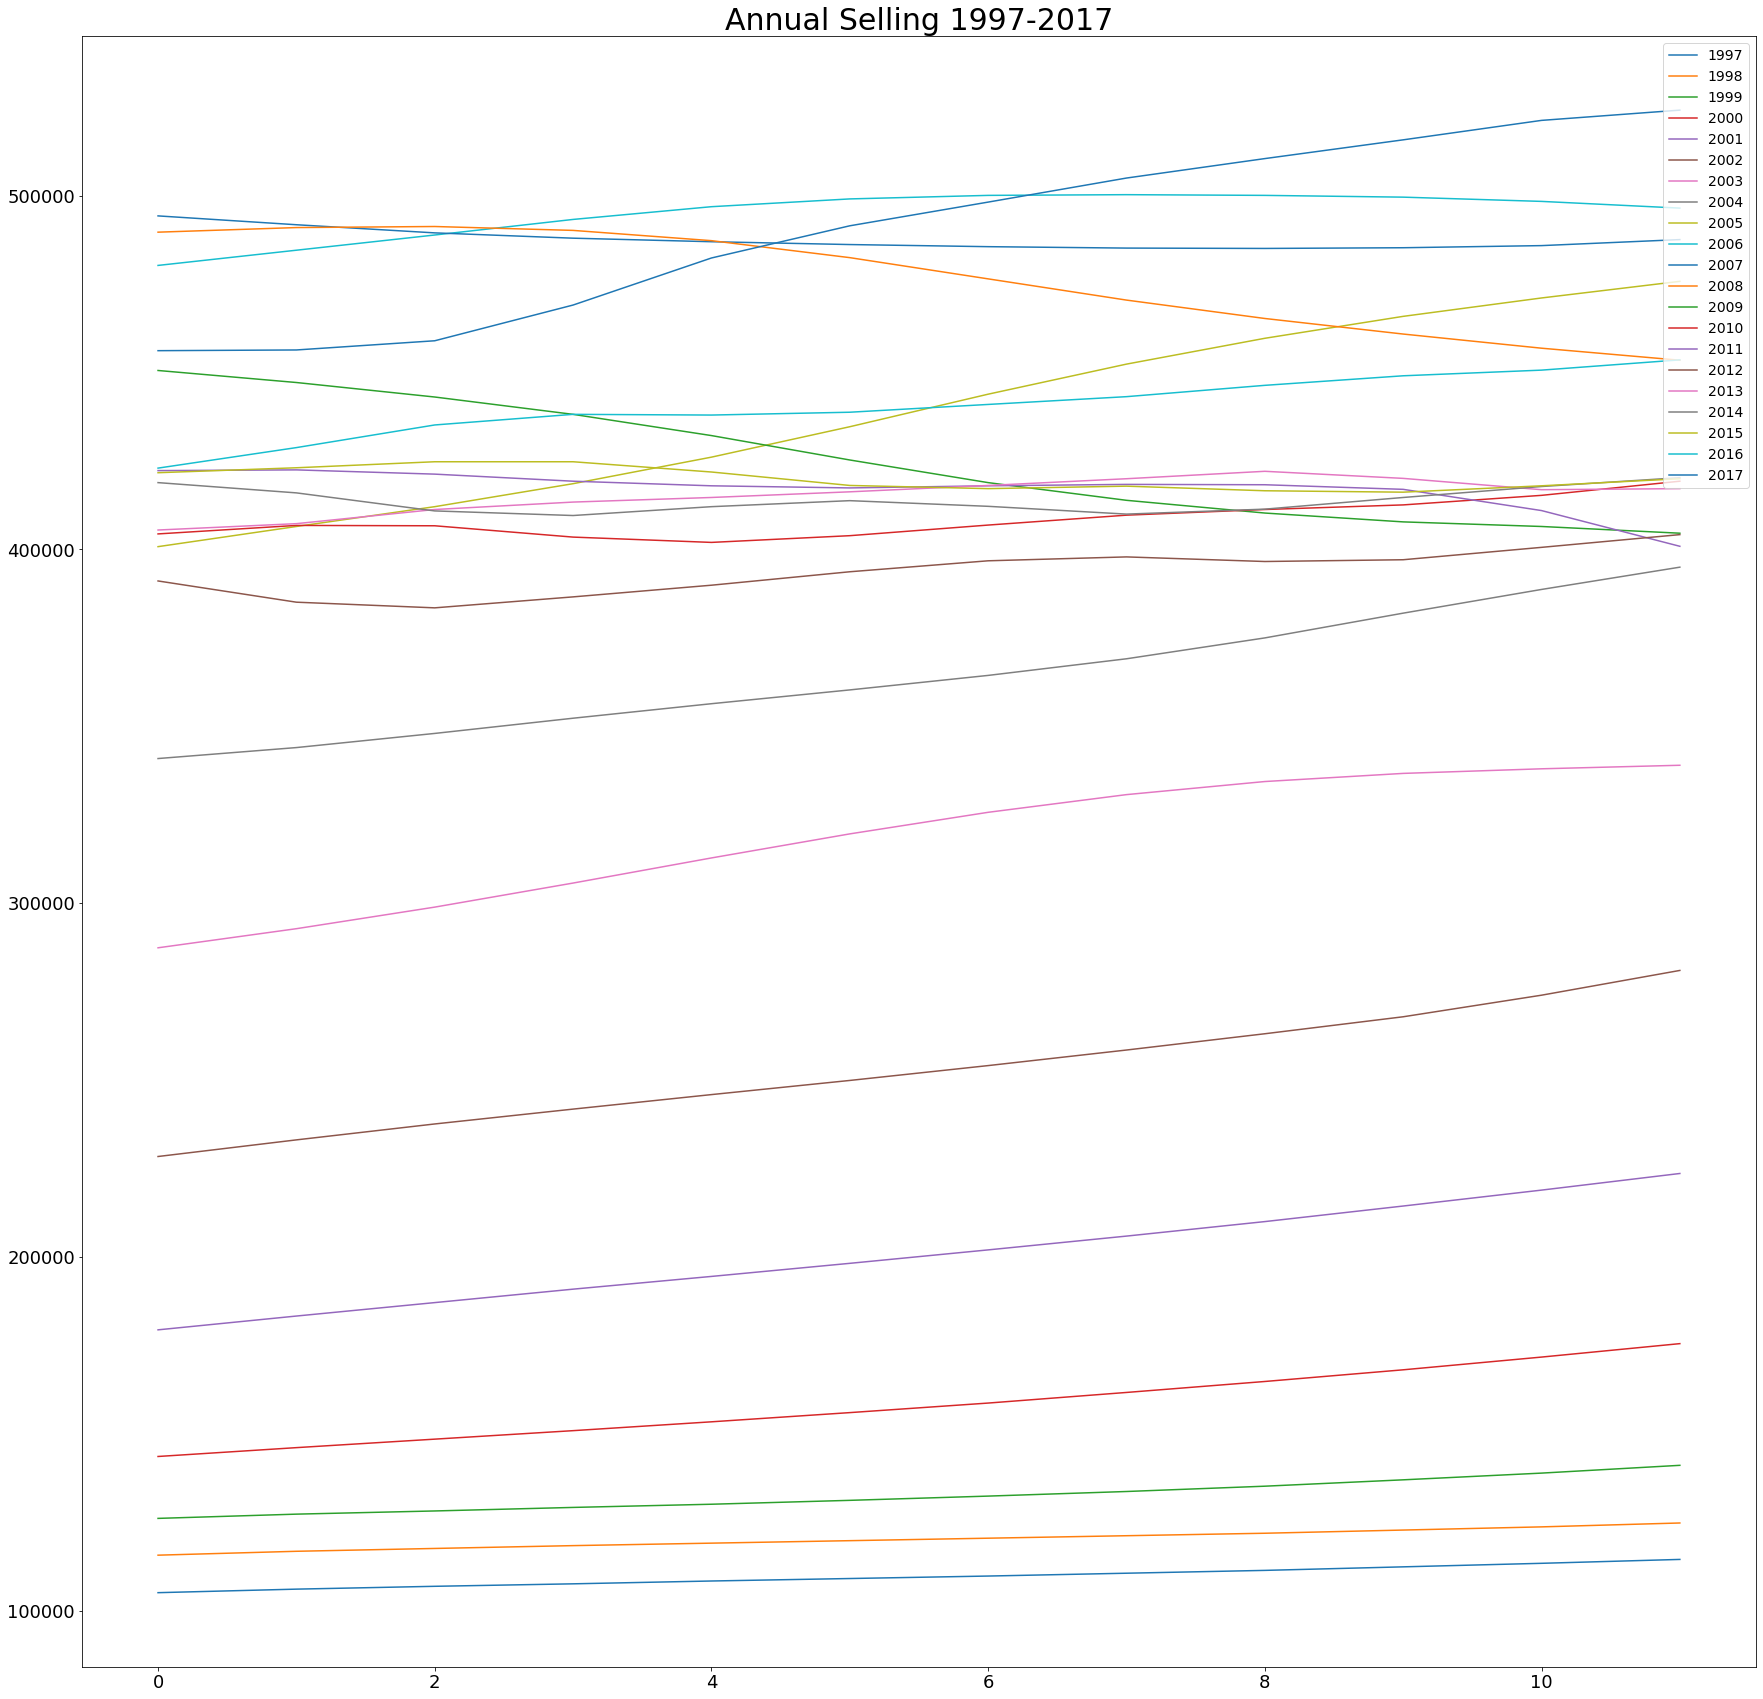

In [263]:
graph_annual(first_zip)

We want to visualize the rolling mean and standard deviation. Stationarity calls for constant mean and variation. If stationarity exists, we should be able to see that in the rolling mean when we visualize it.

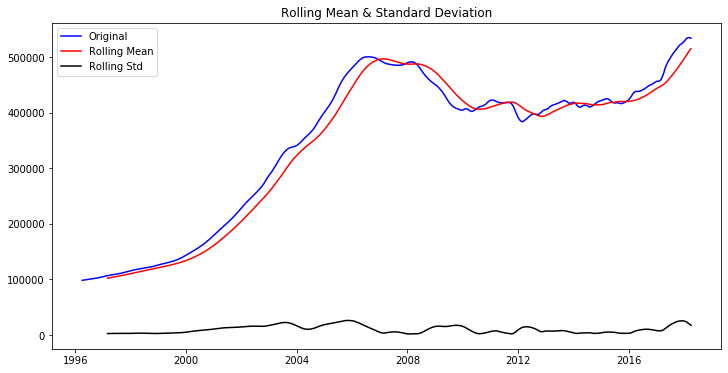

In [264]:
rolling_mean(first_zip)

Here our data picks up quite a bit up until 2008. After a drop off after 2008, the value starts to again pick up around 2017.

In [265]:
dickeyfuller(first_zip)

p-value: 0.49728032696387686
Fail to reject the null hypothesis. Data is not stationary.

Results of Dickey-Fuller test: 

Test Statistic                  -1.572721
p-value                          0.497280
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Since we don't have stationarity, we need to difference our data.

In [266]:
one_diff_first = difference_data(first_zip['value'])

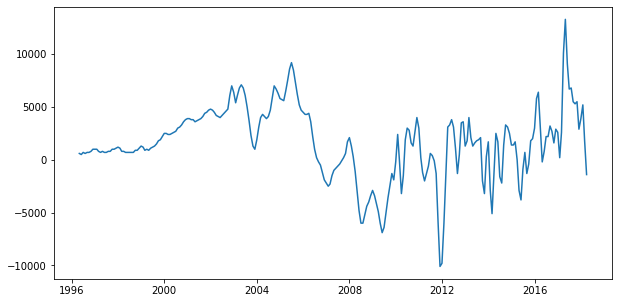

In [276]:
# plot the new distribution

plt.figure(figsize=(10,5))
plt.plot(one_diff_first);

Our differenced data is starting to look more stationary. We can test this by passing this updated series through the Dickey-Fuller test and once again checking to see if we can reject the null hypothesis that there is no stationarity.

In [268]:
dickeyfuller(one_diff_first)

p-value: 0.23689492050748423
Fail to reject the null hypothesis. Data is not stationary.

Results of Dickey-Fuller test: 

Test Statistic                  -2.119123
p-value                          0.236895
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


Because our data is not stationary, we once again difference it and run the Dickey-Fuller test.

In [270]:
two_diff_first = difference_data(one_diff_first)

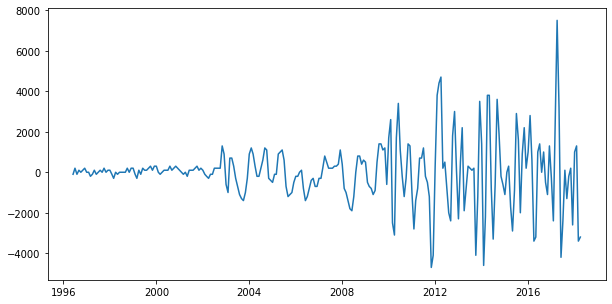

In [275]:
# plot the new distribution

plt.figure(figsize=(10,5))
plt.plot(two_diff_first);

In [271]:
dickeyfuller(two_diff_first)

p-value: 1.5397140271612165e-05
Reject the null hypothesis. Data is stationary.

Results of Dickey-Fuller test: 

Test Statistic                  -5.079716
p-value                          0.000015
#Lags Used                      15.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


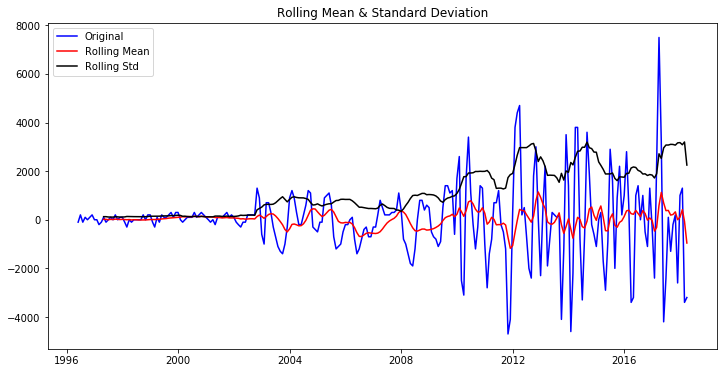

In [274]:
rolling_mean(two_diff_first)

Our data is now stationary. We can look at the ACF & PACF to determine the p and q values for our ARIMA model. From the graphs below, it looks like a value of 2 for both p and q will be good to test. When we run our model, we'll make sure to include (2, 2, 2) as one of the orders we run.

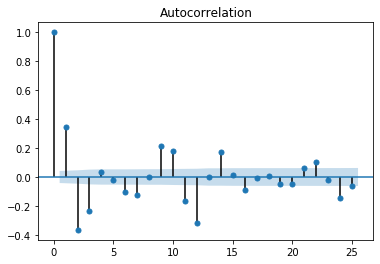

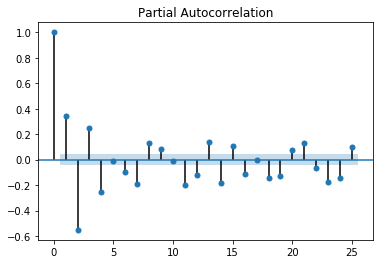

In [277]:
plot_acf_pacf(two_diff_first)

### Second Zipcode: 07302 - Jersey City

Right across from downtown New York is Jersey City which boasts waterfront views and an easy commute to the financial district. Back in 1996, a Jersey City home was only valued at $\\$\$137k on average. As of 2018, it's worth a jaw-dropping $1.4m on average.

In [292]:
second_zip = state[state['Zipcode'] == state_zips[1]]
second_zip.drop(columns=['Zipcode'], inplace=True)
second_zip.head()

,value
time,
1996-04-01,137200.0
1996-05-01,137800.0
1996-06-01,138500.0
1996-07-01,139100.0
1996-08-01,139600.0


Jersey City values started to increase in 1996, but like many zip codes we've investigated, the value dropped off after the housing bubble burst. After remaining dormant for the early 2010s, the value took off 2015, far surpassing it's peak value before the economic downturn.

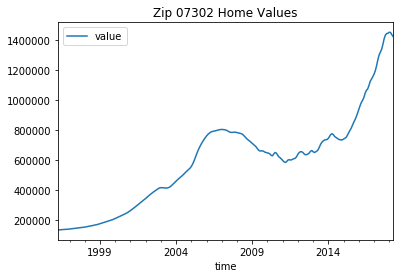

In [280]:
second_zip.plot(title="Zip 07302 Home Values");

We can see below the increase that took place after 2015. Values stayed modest before the uptick, below $\\$\$1m up until 2016.

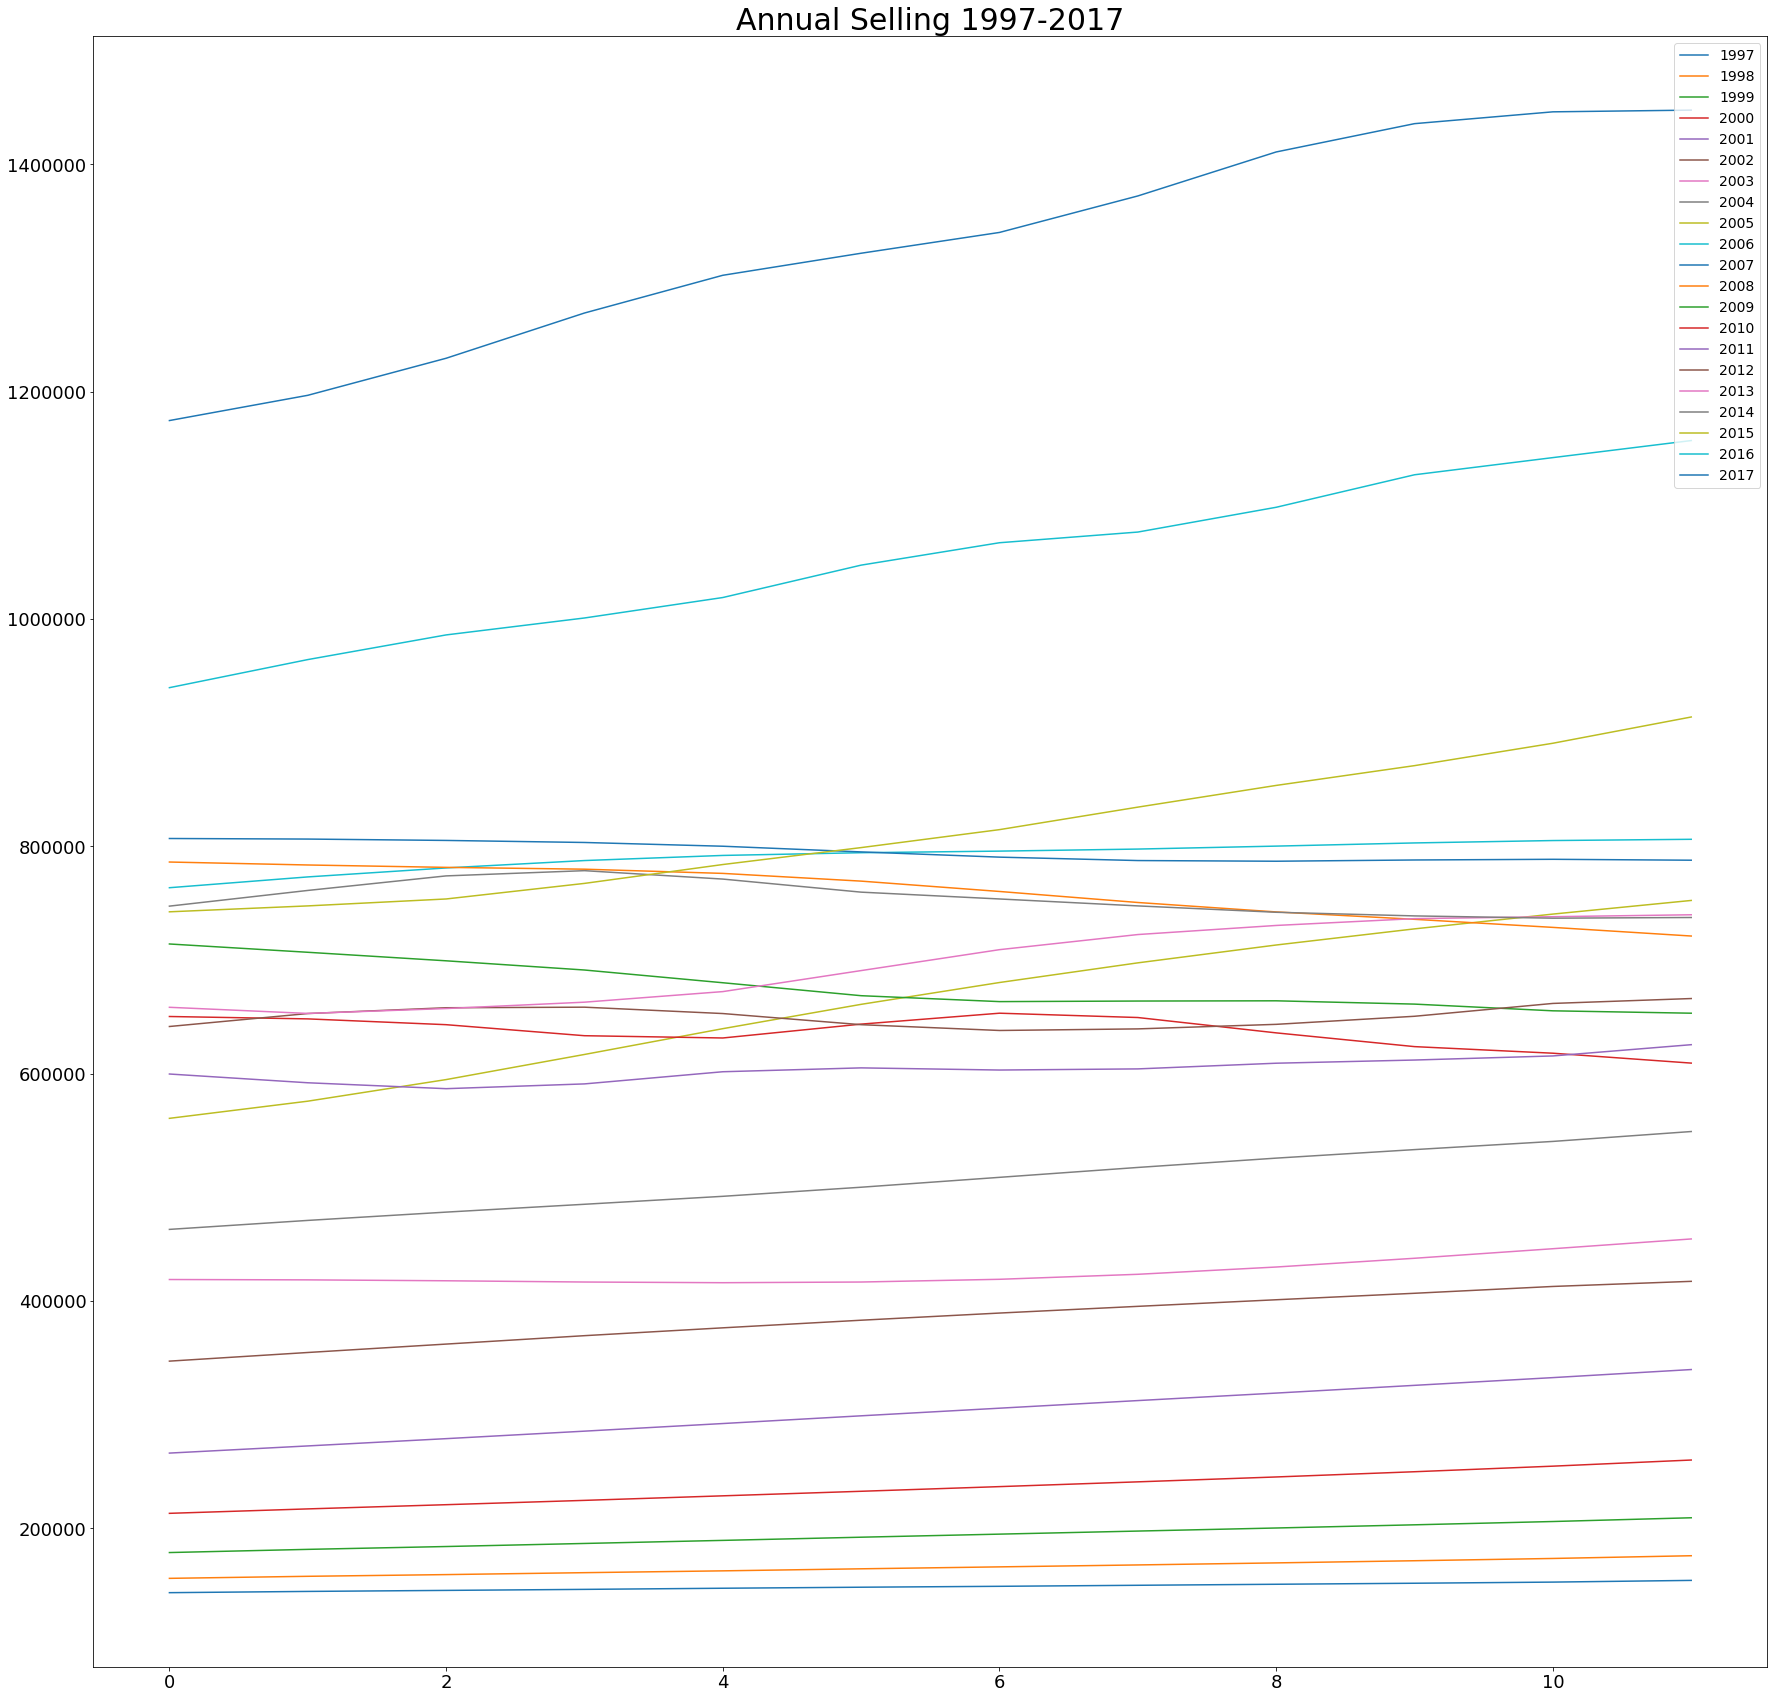

In [281]:
graph_annual(second_zip)

Below we graph the rolling mean and standard deviation compared to the original data. Visually, we can see there is no stationarity in our current data. To confirm, we'll pass the series through the Dickey-Fuller test.

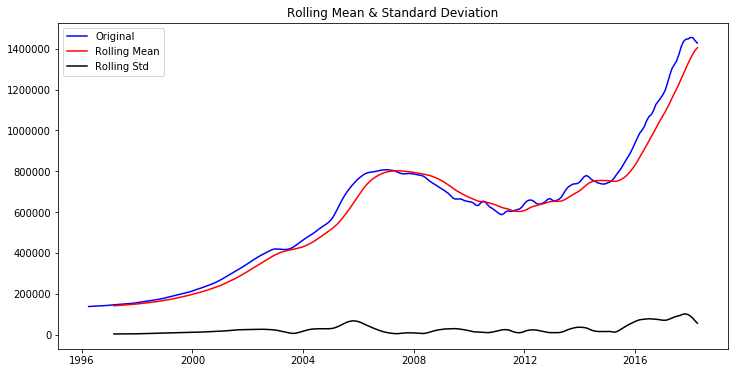

In [282]:
rolling_mean(second_zip)

In [283]:
dickeyfuller(second_zip)

p-value: 0.8818951286500807
Fail to reject the null hypothesis. Data is not stationary.

Results of Dickey-Fuller test: 

Test Statistic                  -0.549950
p-value                          0.881895
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


We're unable to reject the null hypothesis on the original state of our data. It is not stationary. We will need to difference our data and rerun the test.

In [284]:
one_diff_second = difference_data(second_zip)

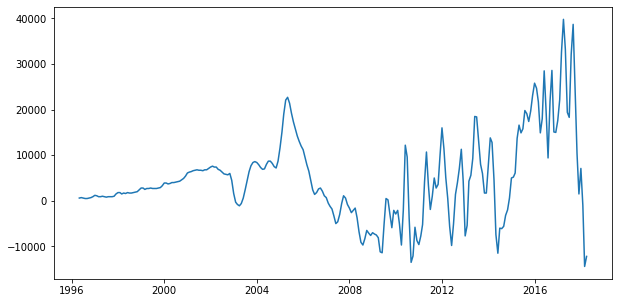

In [285]:
# plot the new distribution

plt.figure(figsize=(10,5))
plt.plot(one_diff_second);

In [286]:
dickeyfuller(one_diff_second)

p-value: 0.3876702496849516
Fail to reject the null hypothesis. Data is not stationary.

Results of Dickey-Fuller test: 

Test Statistic                  -1.785527
p-value                          0.387670
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


Since our data is not yet stationary, we'll difference for a second time.

In [287]:
two_diff_second = difference_data(one_diff_second)

In [288]:
dickeyfuller(two_diff_second)

p-value: 9.523278317428136e-07
Reject the null hypothesis. Data is stationary.

Results of Dickey-Fuller test: 

Test Statistic                -5.657981e+00
p-value                        9.523278e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


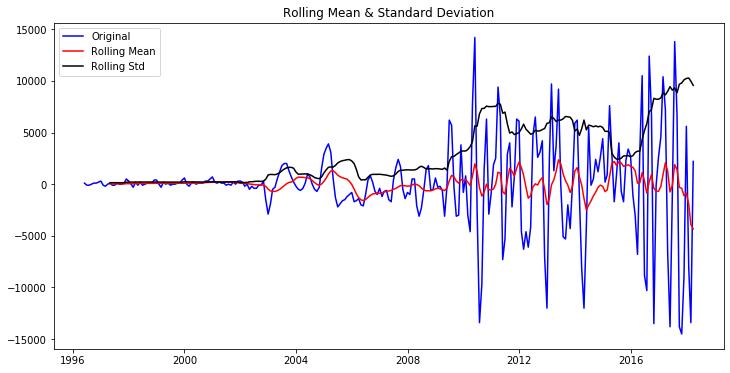

In [289]:
rolling_mean(two_diff_second)

Now that we have stationarity, we can look at our ACF & PACF. We know we needed to difference twice in order to achieve stationarity. Our p value looks like it should be 2 as well and our q looks like 1 will suffice. We'll check when we run the models.

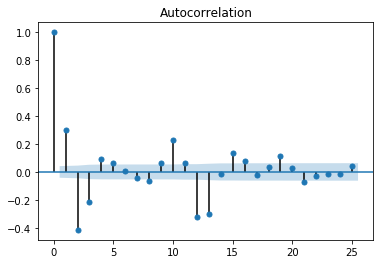

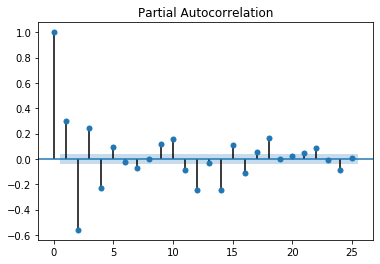

In [290]:
plot_acf_pacf(two_diff_second)

### Third Zipcode: 07030 - Hoboken

Hoboken is also found right across from downtown New York and has been steadily on the incline since 1996. Back then, a home was valued at a meer $\\$\$302k. As of April 2018, that value has skyrocketed to almost $1.9m.

In [296]:
third_zip = state[state['Zipcode'] == state_zips[2]]
third_zip.drop(columns=['Zipcode'], inplace=True)
third_zip.head()

,value
time,
1996-04-01,301600.0
1996-05-01,302700.0
1996-06-01,303800.0
1996-07-01,304800.0
1996-08-01,305800.0


Hoboken saw the same increaes other zip codes saw before the economic crisis. It did decline after 2008, but that bottomed out between 2010 and 2011 and came back stronger than ever. As of 2018, the value reached above $\\$\$1.8m.

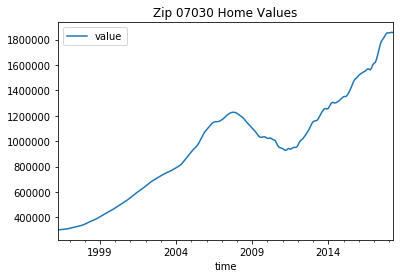

In [294]:
third_zip.plot(title="Zip 07030 Home Values");

Hoboken has come a long way from its humble beginnings back in 1996. After increasing up until 2008 to $\\$\$1.2m, the value was hit by what was going on in the economy. Since 2012, it's value has continued to increase year over year.

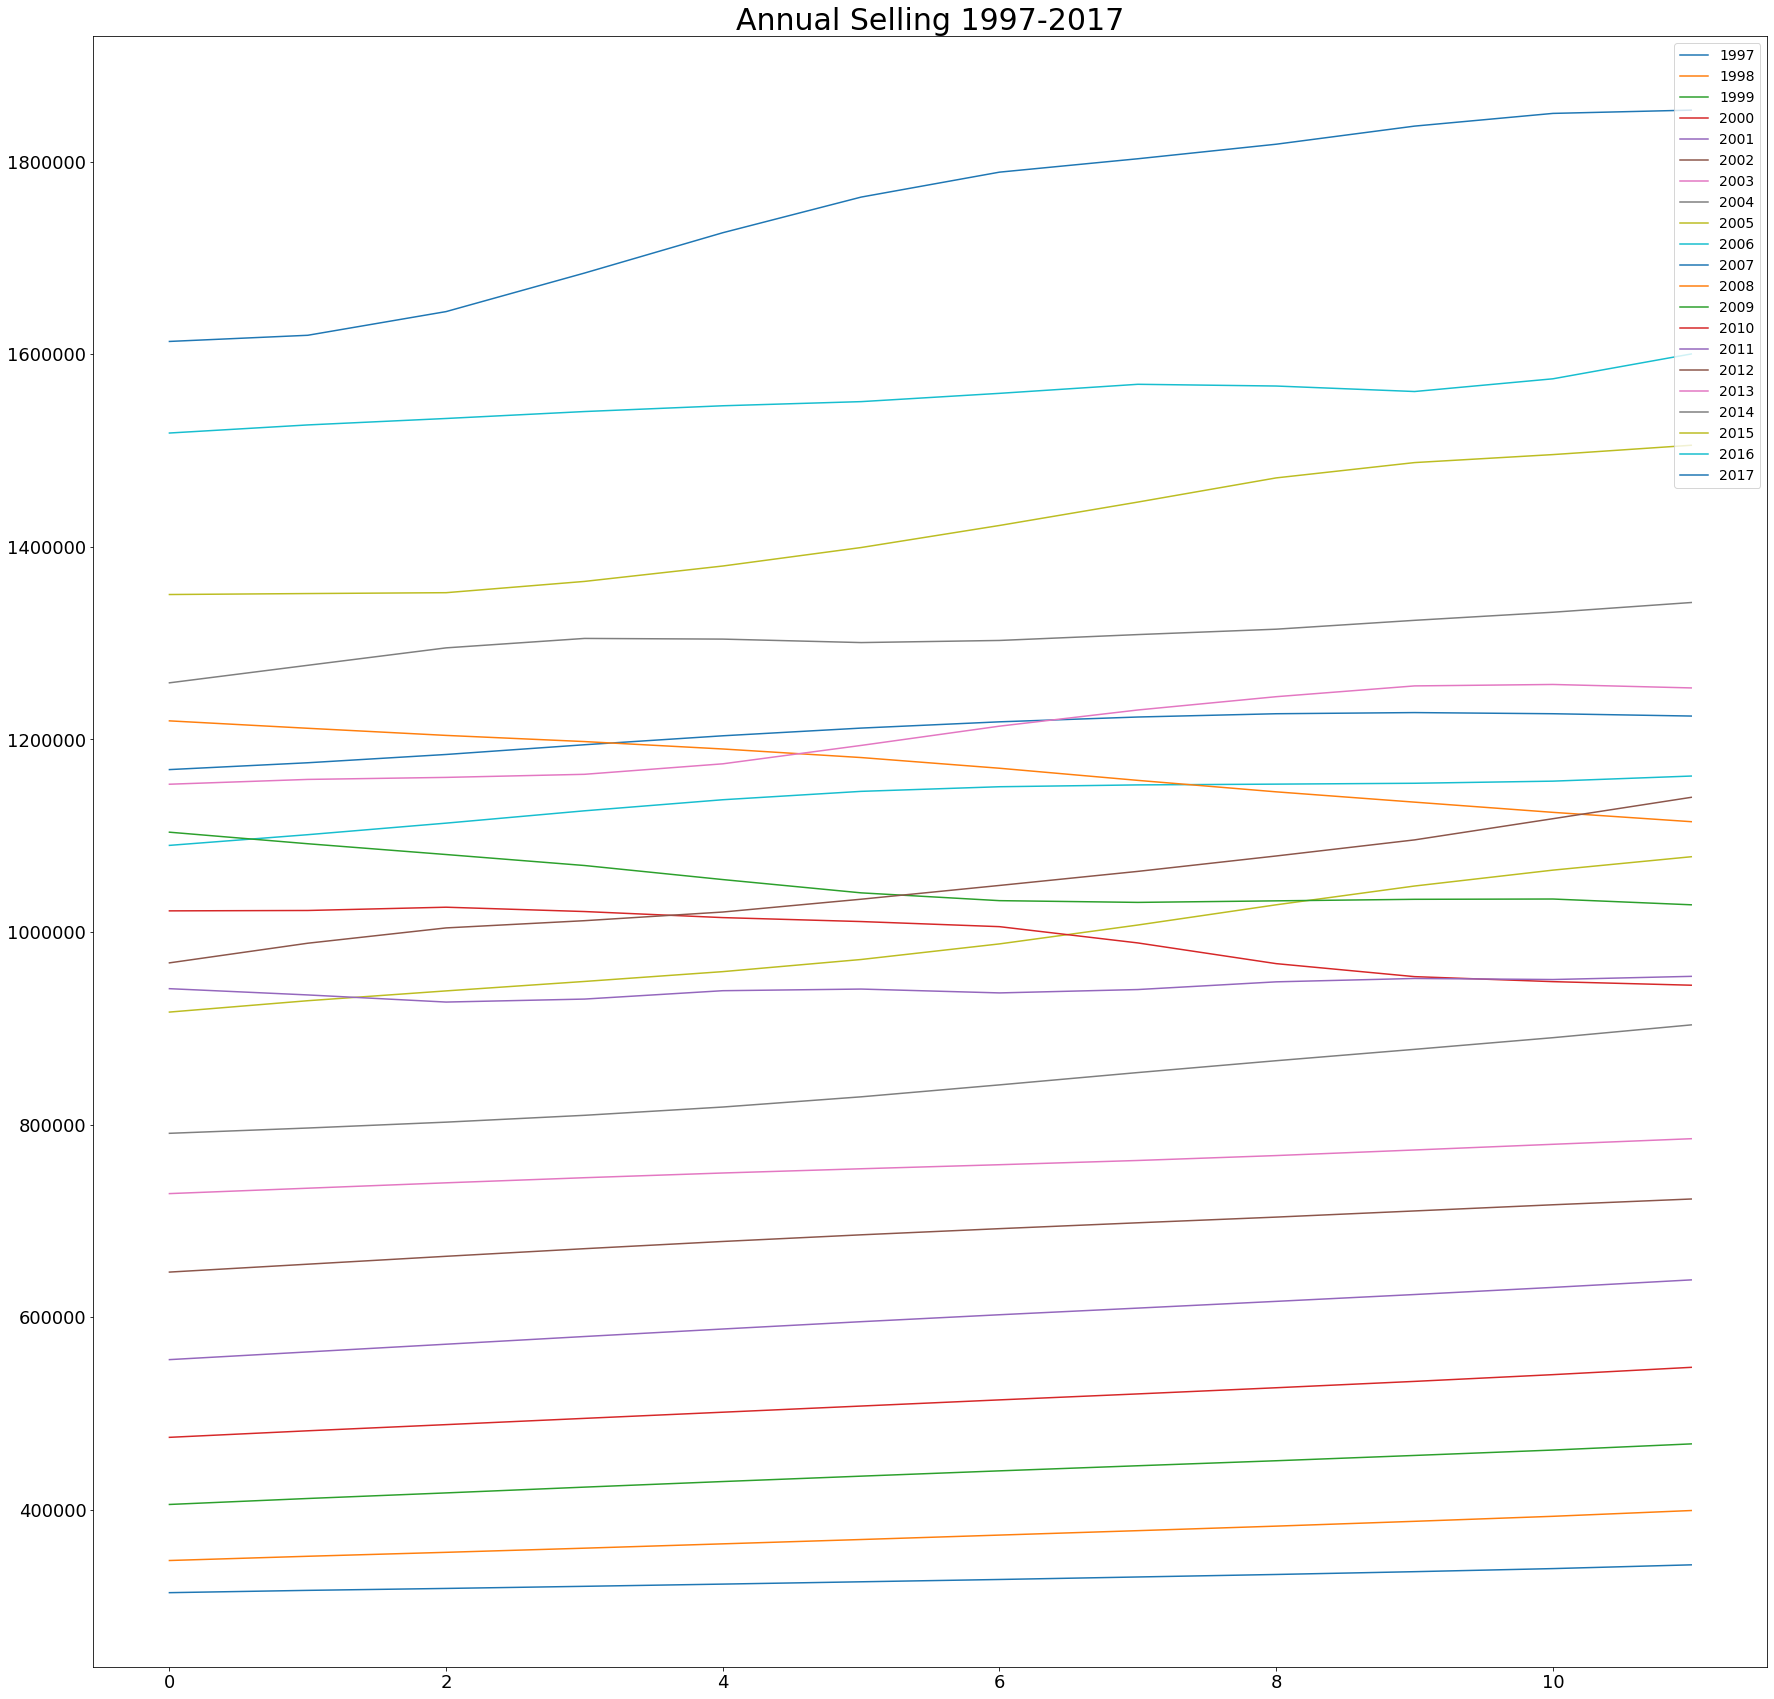

In [298]:
graph_annual(third_zip)

From our earlier analysis, it doesn't look like Hoboken's time series is stationary. We will confirm by looking at the rolling mean and standard deviation compared to the original data and running the Dickey-Fuller test.

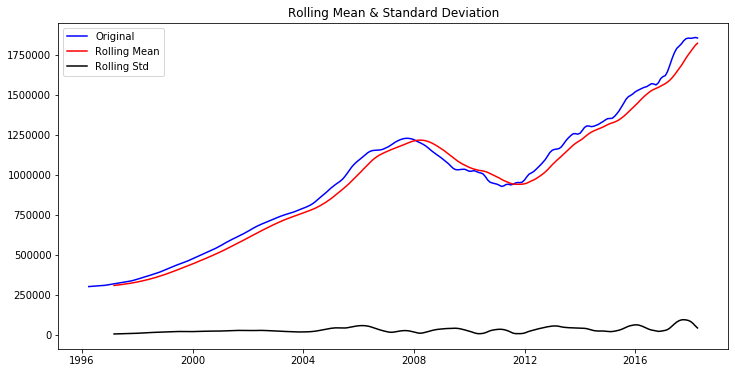

In [300]:
rolling_mean(third_zip)

In [301]:
dickeyfuller(third_zip)

p-value: 0.8913263672522387
Fail to reject the null hypothesis. Data is not stationary.

Results of Dickey-Fuller test: 

Test Statistic                  -0.503527
p-value                          0.891326
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


As we assumed, there is no stationarity in our current data. We will need to difference the data and rerun the test.

In [302]:
one_diff_third = difference_data(third_zip['value'])

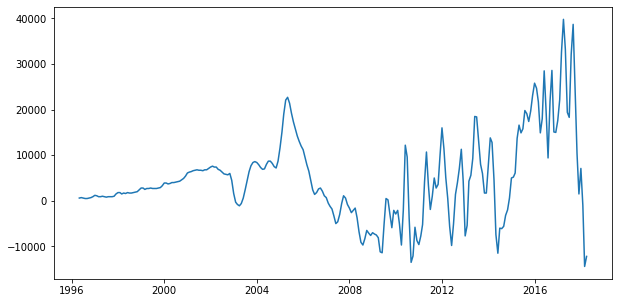

In [303]:
# plot the new distribution

plt.figure(figsize=(10,5))
plt.plot(one_diff_second);

In [304]:
dickeyfuller(one_diff_third)

p-value: 0.3831419551563474
Fail to reject the null hypothesis. Data is not stationary.

Results of Dickey-Fuller test: 

Test Statistic                  -1.794608
p-value                          0.383142
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


Since we still don't have staionarity, it's time to difference the data again and retest.

In [305]:
two_diff_third = difference_data(one_diff_third)

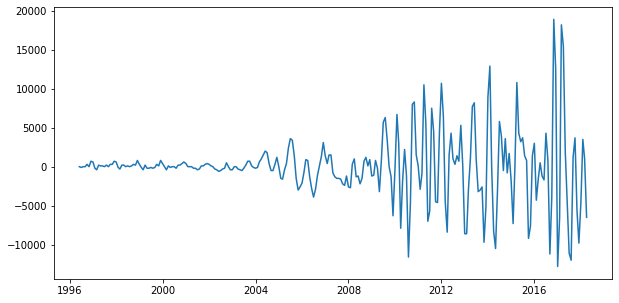

In [306]:
# plot new distribution

plt.figure(figsize=(10,5))
plt.plot(two_diff_third);

In [307]:
dickeyfuller(two_diff_third)

p-value: 7.909779114598399e-07
Reject the null hypothesis. Data is stationary.

Results of Dickey-Fuller test: 

Test Statistic                -5.695039e+00
p-value                        7.909779e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


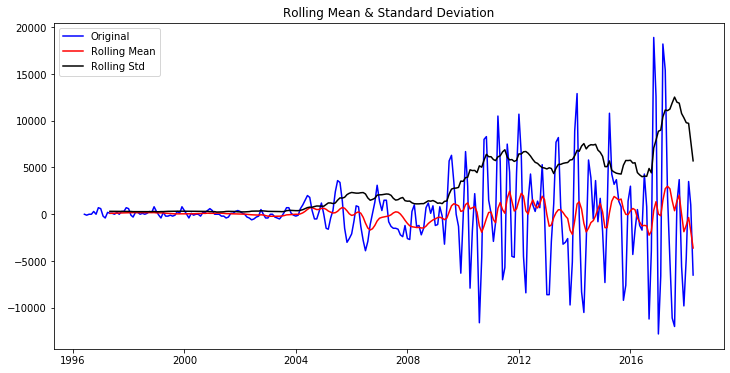

In [308]:
rolling_mean(two_diff_third)

Now that we have stationarity, we can look at our ACF & PACF to decide on what p and q values we know we'll want to include when we test our model. For Hoboken, it looks like a good p value would be 2 and also for q. Let's see when we get to our model evaluation if our estimates are correct.

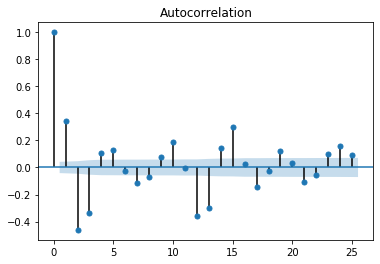

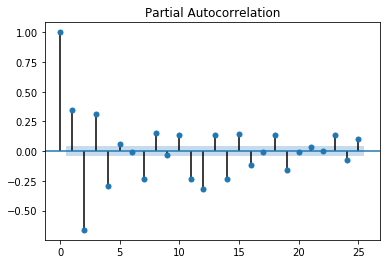

In [309]:
plot_acf_pacf(two_diff_third)

## Modeling

Before we begin modeling, we first set a dataframe that we'll add to as we run through all the order parameters we've designated. The dataframe will provide us with our evaluation metrics. We're interested in balancing the AIC, BIC along with the MSE and RMSE for our test data.

In [325]:
global summary_df
summary_df = pd.DataFrame(columns = ['Zip', 'Order', 'AIC', 'BIC', 'test_mse', 'test_rmse'])
summary_df

,Zip,Order,AIC,BIC,test_mse,test_rmse


In [326]:
from numpy import linalg as LA
LinAlgError = np.linalg.LinAlgError

Now that we have the dataframe set up, we build functions to simplify the modeling process.

In [327]:
### first we created a list for different p, d, and q values we want to check to determine the best model.
### this list is manually entered.
orders = [(1, 0, 0), (1, 1, 0), (2, 1, 3), (3, 1, 1), (2, 2, 2), (4, 1, 1), (3, 2, 3), (3, 2, 1), (3, 2, 2), (1, 0, 1),
         (1, 1, 1), (2, 1, 1), (4, 2, 3), (4, 4, 4), (4, 3, 3), (1, 2, 2), (2, 2, 1), (0, 0, 0), (2, 1, 2), (2, 1, 0), 
         (3, 1, 0), (1, 2, 2), (0, 2, 1), (0, 2, 2)] 


def train_test(df):
    """
    We want to split our data. Because this is time series and not independent, we split our data where we're training
    the model on the older data and then testing the accuracy on the newer data.
    """
    train = df[:'2015-04']
    test = df['2015-05':]
    return train, test

def model_build(zipcode, df, orders):
    """
    This function will run through all of the different orders we've desinated above. We manually enter the zip code
    to later filter on, the dataframe we want to model as well as the list of orders. Should the ARIMA model return
    an error, we continue to the next order option.
    
    When the model successfully passes the order, it will add the evaluation metrics to the dataframe for us to review
    after all models are complete.
    """
    train, test = train_test(df)
    for i in orders:
    # try to run each order option through the model.
    # if the order returns an error, this function will skip that option and move on to the next.
        try:
            zip_ = zipcode
            order = i
            model = ARIMA(train, order=i)
            fitted = model.fit(disp=-1)
            test_fc, se, conf = fitted.forecast(36, alpha=0.05)
            aic = round(fitted.aic, 2)
            bic = round(fitted.bic, 2)
            test_mse = round(mean_squared_error(test.values, test_fc), 2)
            test_rmse = round(np.sqrt(test_mse), 2)
            global summary_df
            summary_df = summary_df.append({'Zip': zip_, 'Order': str(order), 
                                                      'AIC': aic, 'BIC': bic,
                                                      'test_mse': test_mse, 
                                                      'test_rmse': test_rmse},
                                                     ignore_index=True)
        except (LinAlgError, ValueError):
            continue
        
    return summary_df

In [328]:
def best_model(df, order=(0,0,0)):
    """
    Once we evaluate all of the models we were able to run, this function will return the model summary to check for
    significance as well as a graph of our training data, actual values for the test data and the forecasted test data.
    """
    # split the data and pass through the ARIMA using the designated order
    train, test = train_test(df)
    no1_model = ARIMA(train, order=order)
    best_fit = no1_model.fit()
    # forecast for the test data
    test_fc, se, conf = best_fit.forecast(36, alpha=0.05)
    # Make as pandas series
    fc_series = pd.Series(test_fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)
    # print the model summary
    print(best_fit.summary())
    print('\n')
    print('\n')
    # Plot the data and forecast
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [329]:
def future_predict(zipcode, df, order=(0,0,0)):
    """
    We want to be able to predict the future values for these zip codes. This function takes the best model parameters
    for each zip code and calculates the predicted values from 2018-2024 along with the ROI if one was to buy in 2018
    and sell in that year. It also plots these values so we can visually see the different values.
    """
    # spliting the data and passing it through the model to then get forecasts
    train, test = train_test(df)
    model = ARIMA(train, order=order)
    fit = model.fit()
    # get the forecast for the each April for years 2018 - 2024
    april_2018 = round(fit.forecast(36)[0][-1], 2)
    april_2019 = round(fit.forecast(48)[0][-1], 2)
    april_2020 = round(fit.forecast(60)[0][-1], 2)
    april_2021 = round(fit.forecast(72)[0][-1], 2)
    april_2022 = round(fit.forecast(84)[0][-1], 2)
    april_2023 = round(fit.forecast(96)[0][-1], 2)
    april_2024 = round(fit.forecast(108)[0][-1], 2)
    # calculate the ROI if you sold in a given year based on purchasing in 2018
    ROI_2019 = round(april_2019-april_2018, 2)
    ROI_2020 =round(april_2020-april_2018, 2)
    ROI_2021 =round(april_2021-april_2018, 2)
    ROI_2022 = round(april_2022-april_2018, 2)
    ROI_2023 = round(april_2023-april_2018, 2)
    ROI_2024 =  round(april_2024-april_2018, 2)
    # setting up a dictionary for both ROI & Forecasted Values
    dictionary1 = {'2019-04': ROI_2019, '2020-04': ROI_2020, '2021-04': ROI_2021,
                 '2022-04': ROI_2022, '2023-04':ROI_2023,'2024-04': ROI_2024} 
    dictionary = {'2018-04': april_2018, '2019-04': april_2019, '2020-04': april_2020, '2021-04': april_2021,
                 '2022-04': april_2022, '2023-04': april_2023, '2024-04': april_2024}
    # saving as dataframes to then plot
    dataframe = pd.DataFrame(dictionary.values(), index=dictionary.keys(), columns=['Predict_Value'])
    dataframe.plot(kind='bar', title="Future Home Values", figsize=(8, 4), color = 'coral')
    dataframe1 = pd.DataFrame(dictionary1.values(), index=dictionary1.keys(), columns=['ROI'])
    dataframe1.plot(kind='bar', title="Retrun on Investment", figsize=(8, 4), color = 'forestgreen')
    # print values for interpretation
    print(zipcode)
    print("April 2018 actual value: ", df.value[-1])
    print("April 2018 forecasted value: ", april_2018)
    print("April 2019 forecasted value: ", april_2019, ", ROI: ", round(april_2019-april_2018, 2))
    print("April 2020 forecasted value: ", april_2020, ", ROI: ", round(april_2020-april_2018, 2))
    print("April 2021 forecasted value: ", april_2021, ", ROI: ", round(april_2021-april_2018, 2))
    print("April 2022 forecasted value: ", april_2022, ", ROI: ", round(april_2022-april_2018, 2))
    print("April 2023 forecasted value: ", april_2023, ", ROI: ", round(april_2023-april_2018, 2))
    print("April 2024 forecasted value: ", april_2024, ", ROI: ", round(april_2024-april_2018, 2))

In [330]:
### run the different models for each of the zip codes.

model_build('7756', first_zip, orders)
model_build('7302', second_zip, orders)
model_build('7030', third_zip, orders)

,Zip,Order,AIC,BIC,test_mse,test_rmse
0,7756,"(1, 0, 0)",4413.98,4424.29,3.043614e+09,55168.96
1,7756,"(1, 1, 0)",3910.33,3920.61,1.488461e+09,38580.58
2,7756,"(2, 1, 3)",3735.81,3759.81,1.466763e+09,38298.34
3,7756,"(3, 1, 1)",3774.21,3794.79,1.932763e+09,43963.20
4,7756,"(2, 2, 2)",3735.41,3755.96,5.534116e+09,74391.64
5,7756,"(4, 1, 1)",3773.57,3797.58,1.886204e+09,43430.45
6,7756,"(3, 2, 3)",3724.07,3751.47,4.431059e+09,66566.20
7,7756,"(3, 2, 1)",3763.56,3784.11,5.361607e+09,73222.99
8,7756,"(3, 2, 2)",3728.09,3752.06,3.808405e+09,61712.28
9,7756,"(1, 1, 1)",3801.99,3815.71,1.603790e+09,40047.35


In [331]:
first_zip_models = summary_df[summary_df['Zip'] == '7756']
second_zip_models = summary_df[summary_df['Zip'] == '7302'] 
third_zip_models = summary_df[summary_df['Zip'] == '7030'] 

## Evaluating Models

### First Zipcode: 07756 - Ocean Grove

We separated our summary dataframe into individual dataframes to evaluate. We'll start with Ocean Grove. When we looked at the ACF & PACF, we determined the order could possibly be (2, 2, 2). We'll look to see how that performed, but will also look at the AIC and Test RMSE to determine our best model. We want this model to be as accurate as possible so we want to minimize our error.

In [137]:
first_zip_models

,Zip,Order,AIC,BIC,test_mse,test_rmse
0,first,"(1, 0, 0)",4413.98,4424.29,3.043614e+09,55168.96
1,first,"(1, 1, 0)",3910.33,3920.61,1.488461e+09,38580.58
2,first,"(2, 1, 3)",3735.81,3759.81,1.466763e+09,38298.34
3,first,"(3, 1, 1)",3774.21,3794.79,1.932763e+09,43963.20
4,first,"(2, 2, 2)",3735.41,3755.96,5.534116e+09,74391.64
5,first,"(4, 1, 1)",3773.57,3797.58,1.886204e+09,43430.45
6,first,"(3, 2, 3)",3724.07,3751.47,4.431059e+09,66566.20
7,first,"(3, 2, 1)",3763.56,3784.11,5.361607e+09,73222.99
8,first,"(3, 2, 2)",3728.09,3752.06,3.808405e+09,61712.28
9,first,"(1, 1, 1)",3801.99,3815.71,1.603790e+09,40047.35


In [332]:
first_zip_models.sort_values('AIC', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
11,7756,"(4, 2, 3)",3721.79,3752.61,4.066966e+09,63772.77
6,7756,"(3, 2, 3)",3724.07,3751.47,4.431059e+09,66566.20
8,7756,"(3, 2, 2)",3728.09,3752.06,3.808405e+09,61712.28


In [333]:
first_zip_models.sort_values('test_rmse', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
15,7756,"(2, 1, 2)",3738.63,3759.21,1.318236e+09,36307.52
16,7756,"(2, 1, 0)",3859.46,3873.18,1.331614e+09,36491.29
2,7756,"(2, 1, 3)",3735.81,3759.81,1.466763e+09,38298.34


By the looks of our models, the best one will be (2, 1, 2). While (4, 2, 3) has a better AIC, it overfits to our training data and our test RMSE comes back almost double what the simpler model does. In choosing (2, 1, 2), we don't sacrifice much with our AIC so we're comfortably choosing (2, 1, 2) as our best model. (2, 2, 2) returned an AIC not much higher than (4, 2, 3), but then was overfit to our training data.

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  228
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1863.317
Method:                       css-mle   S.D. of innovations            835.287
Date:                Thu, 07 May 2020   AIC                           3738.635
Time:                        13:30:46   BIC                           3759.211
Sample:                    05-01-1996   HQIC                          3746.936
                         - 04-01-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1378.8287    693.615      1.988      0.047      19.368    2738.289
ar.L1.D.value     0.2677      0.060      4.433      0.000       0.149       0.386
ar.L2.D.value     0.4407      0.061     

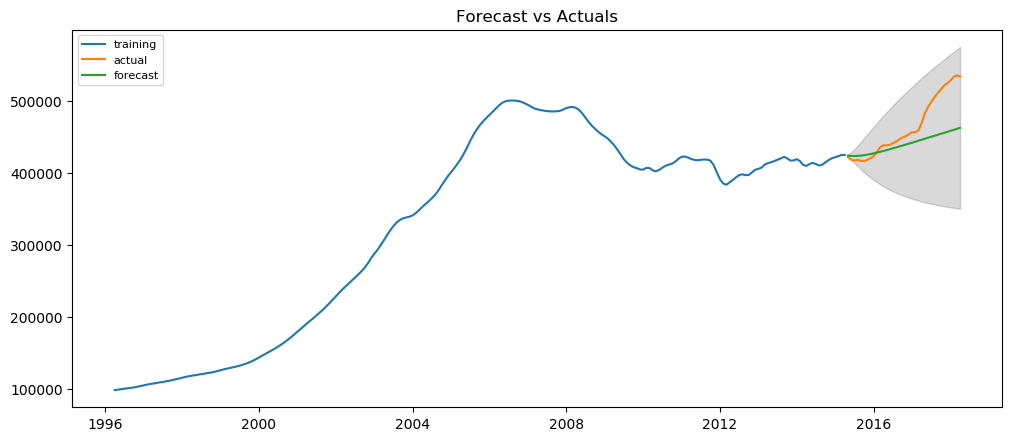

In [334]:
best_model(first_zip, order=(2, 1, 2))

One thing we immediately notice is that while this model was the best of the ones that we tried, it's undervaluing our actuals in our test data. It's the best of what we have, but it would be worthwhile to investigate further what values would more accurately capture the pickup in value for Ocean Grove.

### Second Zipcode: 07302 - Jersey City

In [335]:
### display total model recap
### the second zip code ran through 20 models.

second_zip_models

,Zip,Order,AIC,BIC,test_mse,test_rmse
21,7302,"(1, 0, 0)",4732.64,4742.95,1.888396e+11,434556.82
22,7302,"(1, 1, 0)",4325.47,4335.75,9.361203e+10,305960.83
23,7302,"(2, 1, 3)",4156.59,4180.60,9.079787e+10,301326.85
24,7302,"(3, 1, 1)",4182.68,4203.25,9.156738e+10,302601.02
25,7302,"(2, 2, 2)",4173.78,4194.33,5.321263e+10,230678.64
26,7302,"(4, 1, 1)",4183.34,4207.34,9.527961e+10,308673.95
27,7302,"(3, 2, 3)",4141.93,4169.33,6.589045e+10,256691.35
28,7302,"(3, 2, 1)",4176.74,4197.29,8.727053e+09,93418.70
29,7302,"(3, 2, 2)",4168.09,4192.07,9.419315e+10,306909.02
30,7302,"(1, 1, 1)",4202.98,4216.69,9.861560e+10,314031.20


In [336]:
second_zip_models.sort_values('AIC', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
27,7302,"(3, 2, 3)",4141.93,4169.33,6.589045e+10,256691.35
32,7302,"(4, 2, 3)",4141.93,4172.76,6.266063e+10,250321.06
23,7302,"(2, 1, 3)",4156.59,4180.60,9.079787e+10,301326.85


In [337]:
second_zip_models.sort_values('test_rmse', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
40,7302,"(0, 2, 1)",4203.19,4213.46,1.433661e+09,37863.71
41,7302,"(0, 2, 2)",4200.09,4213.79,3.234853e+09,56875.76
28,7302,"(3, 2, 1)",4176.74,4197.29,8.727053e+09,93418.70


Jersey City proved to be tricky in balancing the evaluation metrics. While the more complicated (3, 2, 3) model gave us the lowest AIC value, (0, 2, 1) was the best in RMSE and it was significantly below all other models. We know we want an accurate model so we've decided to use (0, 2, 1) as our best model.

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  227
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -2098.593
Method:                       css-mle   S.D. of innovations           2499.881
Date:                Thu, 07 May 2020   AIC                           4203.186
Time:                        13:35:09   BIC                           4213.461
Sample:                    06-01-1996   HQIC                          4207.332
                         - 04-01-2015                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             79.5348    292.864      0.272      0.786    -494.469     653.539
ma.L1.D2.value     0.7684      0.036     21.549      0.000       0.699       0.838
                                    

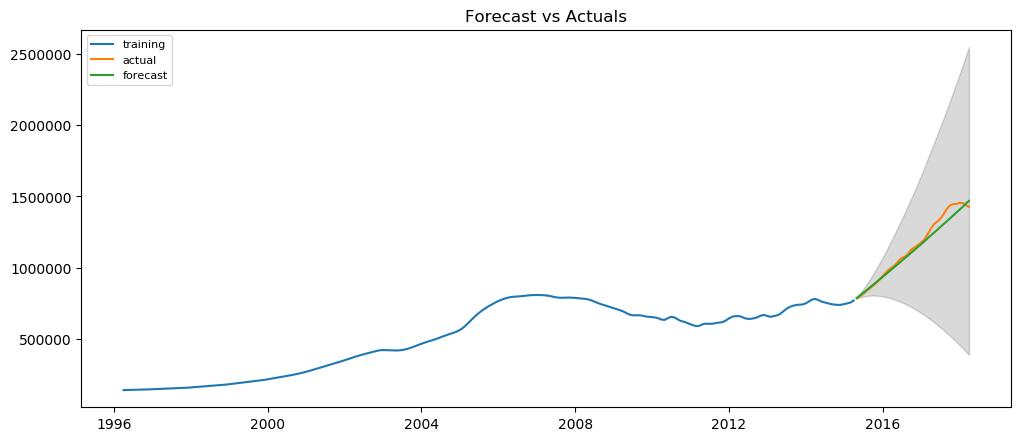

In [339]:
best_model(second_zip, order=(0, 2, 1))

That forecast line hugs pretty close to the actuals. Even though it wasn't our best AIC value, it looks like we were able to appropriate fit the model to predict correctly for future values.

### Third Zipcode: 07030 - Hoboken

Hoboken successfully ran through 16 models that we choose from.

In [345]:
third_zip_models

,Zip,Order,AIC,BIC,test_mse,test_rmse
42,7030,"(1, 0, 0)",4827.49,4837.79,9.410191e+10,306760.35
43,7030,"(1, 1, 0)",4341.08,4351.37,2.461533e+10,156892.72
44,7030,"(2, 1, 3)",4123.17,4147.17,2.773246e+10,166530.64
45,7030,"(3, 1, 1)",4166.62,4187.20,1.948692e+10,139595.57
46,7030,"(2, 2, 2)",4154.35,4174.90,2.248487e+09,47418.21
47,7030,"(4, 1, 1)",4168.45,4192.46,1.984399e+10,140868.69
48,7030,"(3, 2, 3)",4106.65,4134.05,2.085775e+10,144422.12
49,7030,"(3, 2, 1)",4154.41,4174.96,1.893770e+09,43517.47
50,7030,"(3, 2, 2)",4151.96,4175.94,4.726654e+09,68750.67
51,7030,"(2, 1, 1)",4214.63,4231.78,2.218275e+10,148938.76


In [346]:
third_zip_models.sort_values('AIC', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
48,7030,"(3, 2, 3)",4106.65,4134.05,2.085775e+10,144422.12
52,7030,"(4, 2, 3)",4116.91,4147.74,3.307291e+10,181859.59
44,7030,"(2, 1, 3)",4123.17,4147.17,2.773246e+10,166530.64


In [347]:
third_zip_models.sort_values('test_rmse', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
53,7030,"(2, 2, 1)",4152.42,4169.54,1.874860e+09,43299.65
49,7030,"(3, 2, 1)",4154.41,4174.96,1.893770e+09,43517.47
58,7030,"(0, 2, 2)",4183.54,4197.24,1.922161e+09,43842.45


Like we've seen before, the more complicated model (3, 2, 3) gives us the best AIC value but it doesn't perform that well for our test RMSE. In this instance, (2, 2, 1) is our best model. It has the lowest RMSE and while we're giving up 152 points on our AIC, we feel more comfortable choosing the simpler model to use for furture forecasts.

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  227
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -2071.209
Method:                       css-mle   S.D. of innovations           2212.267
Date:                Thu, 07 May 2020   AIC                           4152.418
Time:                        13:40:22   BIC                           4169.543
Sample:                    06-01-1996   HQIC                          4159.328
                         - 04-01-2015                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             48.2472    175.378      0.275      0.783    -295.487     391.981
ar.L1.D2.value     0.4549      0.069      6.557      0.000       0.319       0.591
ar.L2.D2.value    -0.6082      0.060

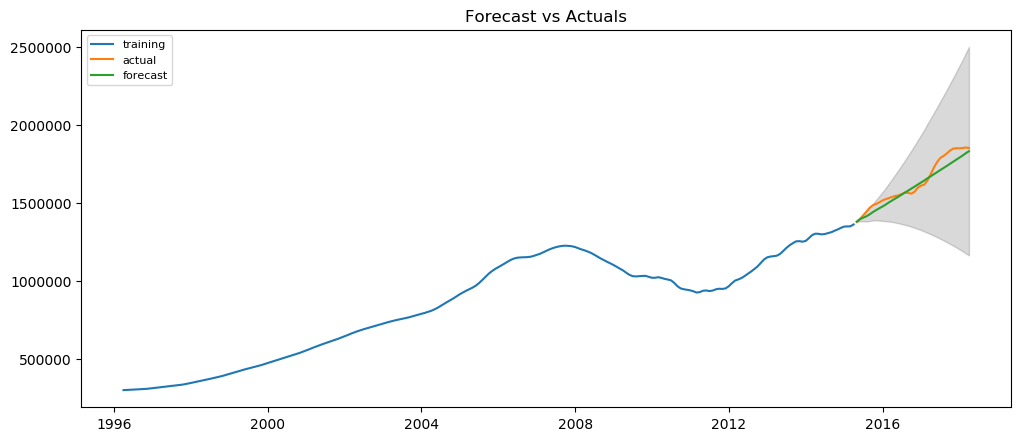

In [348]:
best_model(third_zip, order=(2, 2, 1))

Our forecast seems to follow the actuals pretty well here. We don't look like we're undervaluing the home prices, but we're also not overvaluing. We're set to proceed to forecasting future prices, up until April 2024 with our (2, 2, 1) model.

## Predicting Future Home Values

Now that we have our best models, we want to predict values in the future. Thankfully, we have our future_predict function all set to predict the value each year from 2018-2024.

07756 - Ocean Grove
April 2018 actual value:  533700.0
April 2018 forecasted value:  458755.91
April 2019 forecasted value:  474728.57 , ROI:  15972.66
April 2020 forecasted value:  490928.69 , ROI:  32172.78
April 2021 forecasted value:  507202.47 , ROI:  48446.56
April 2022 forecasted value:  523500.1 , ROI:  64744.19
April 2023 forecasted value:  539805.46 , ROI:  81049.55
April 2024 forecasted value:  556113.32 , ROI:  97357.41


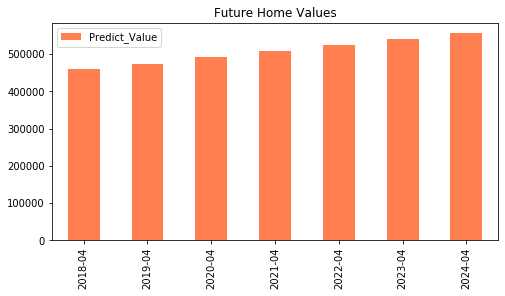

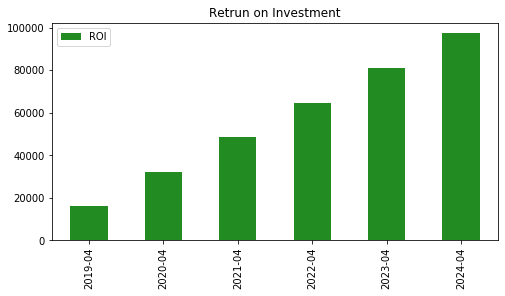

In [349]:
future_predict('07756 - Ocean Grove', first_zip, order=(2, 1, 3))

According to our model, Ocean Grove value isn't expected to grow by much. The caveat to this is that our 2018 value is actually a lot higher than our where we forecasted. We know we have some work to do with this data. We're undervaluing the market as of right now.

07302 - Jersey City
April 2018 actual value:  1427300.0
April 2018 forecasted value:  1468845.77
April 2019 forecasted value:  1725533.72 , ROI:  256687.95
April 2020 forecasted value:  1993674.69 , ROI:  524828.92
April 2021 forecasted value:  2273268.67 , ROI:  804422.9
April 2022 forecasted value:  2564315.67 , ROI:  1095469.9
April 2023 forecasted value:  2866815.68 , ROI:  1397969.91
April 2024 forecasted value:  3180768.7 , ROI:  1711922.93


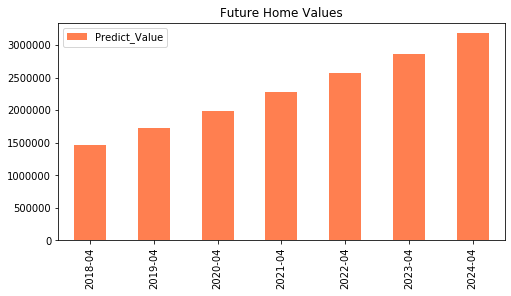

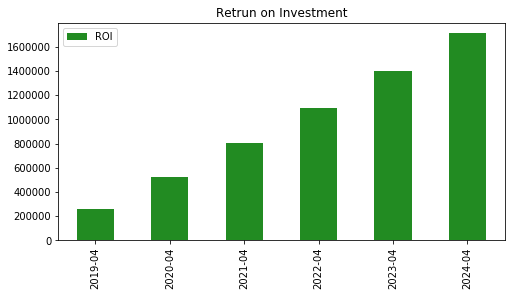

In [341]:
future_predict('07302 - Jersey City', second_zip, order=(0, 2, 1))

We're predicting Jersey City to continue it's growth through 2024 where the value is expected to grow up to almost $\\$\$3.2m. If you bought in April 2018 and sold by then, you can expect to make a $1.7m return on that purchase.

07030 - Hoboken
April 2018 actual value:  1854300.0
April 2018 forecasted value:  1834160.11
April 2019 forecasted value:  2002784.74 , ROI:  168624.63
April 2020 forecasted value:  2178357.58 , ROI:  344197.47
April 2021 forecasted value:  2360877.99 , ROI:  526717.88
April 2022 forecasted value:  2550345.99 , ROI:  716185.88
April 2023 forecasted value:  2746761.59 , ROI:  912601.48
April 2024 forecasted value:  2950124.77 , ROI:  1115964.66


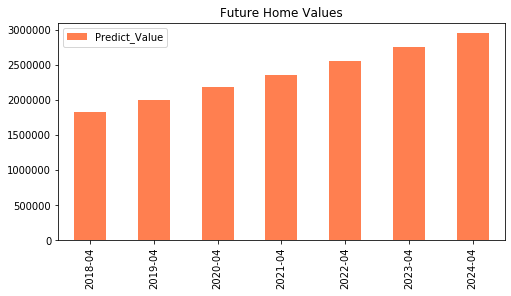

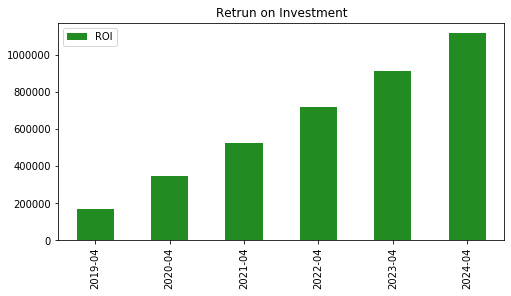

In [342]:
future_predict('07030 - Hoboken', third_zip, order=(2, 2, 1))

Where Jersey City is expected to double in value over the next few years, Hoboken is seeing a more modest increase in its value. Homes as of April 2018 actualized at $\\$\$1.85m and by April 2024, we're projecting them to be worth just shy of $3m.